This is an old blog post, see the newer version in [this post](https://laurentperrinet.github.io/sciblog/posts/2017-03-14-reproducing-olshausens-classical-sparsenet.html)

 <!-- TEASER_END -->
 

 * This notebook tries to reproduce the learning strategy specified in the framework of the [SparseNet algorithm from Bruno Olshausen](http://redwood.berkeley.edu/bruno/sparsenet/). It allows to efficiently code natural image patches by constraining the code to be sparse.

 * the underlying machinery uses the dictionary learning used in the [image denoising](http://scikit-learn.org/stable/_downloads/plot_image_denoising.py) example from ``sklearn`` and our aim here is to show that a novel ingredient is necessary to reproduce Olshausen's results.

 * All these code bits are regrouped in the [SHL scripts repository](https://github.com/bicv/SHL_scripts) (where you will also find some older matlab code). You may install it using

```
    pip install git+https://github.com/bicv/SHL_scripts
    
```

 * the goal of this notebooks is to illustrate a [PR to sklearn](https://github.com/scikit-learn/scikit-learn/pull/4693)
 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import pandas as pd
import seaborn as sns
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


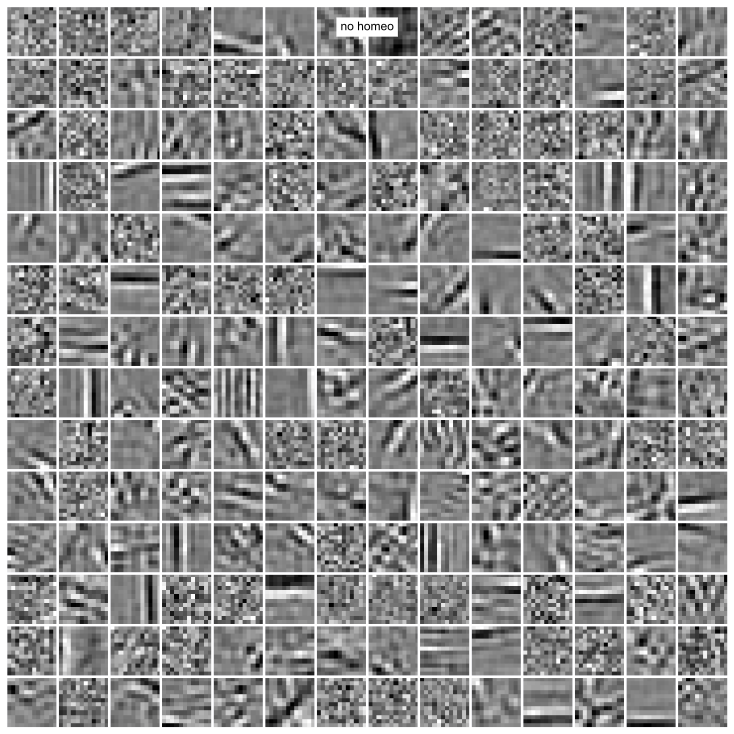

In [2]:
from shl_scripts import SHL
database = '/Users/lolo/pool/science/BICV/SHL_scripts/database/'
DEBUG_DOWNSCALE, verbose = 100, 0
DEBUG_DOWNSCALE, verbose = 1, 0
shl = SHL(database=database, DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, verbose=verbose, eta_homeo=0.)
fig, ax = shl.show_dico(shl.learn_dico(), title='no homeo')
fig.show()

## testing sklearn's dictionary learning

Basically, we will here replicate the same [image denoising](http://scikit-learn.org/stable/_downloads/plot_image_denoising.py) code from ``sklearn`` (see also below), but with:
 
 - no distorsion of image denoising -- we will assess the results by the coding efficiency,
 - whitening of the images (as in Olshausen) befor taking patches,
 - bigger patches,
 - a bigger set of natural images,
 - a longer learning
 - testing different ``transform_algorithm``s as learning and coding algorithms,
 - uses online learning from the third example
 
What differs from the original algorithm is mainly 
 
 - the learning method is modified,
 - the way that the norm of the filters is controlled. Here, sklearn simply assumes that $ || V_k ||_2 = 1$,  $\forall k$ (with $0 <= k < n_{components}$). We will see that this may be a problem. 
 
Let's start with the learning:

Dictionary learned from image patches using Orthogonal Matching Pursuit 10 atom
Dictionary learned from image patches using Orthogonal Matching Pursuit alpha 0.9
Dictionary learned from image patches using Least-angle regression 5 atoms
Dictionary learned from image patches using Least-angle regression 5 atoms
Dictionary learned from image patches using Least-angle regression 5 atoms


/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


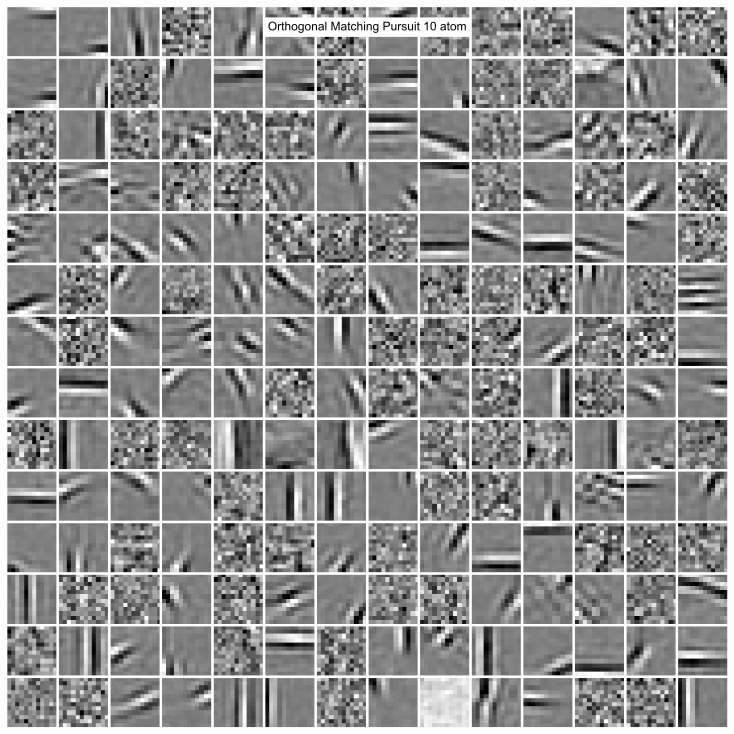

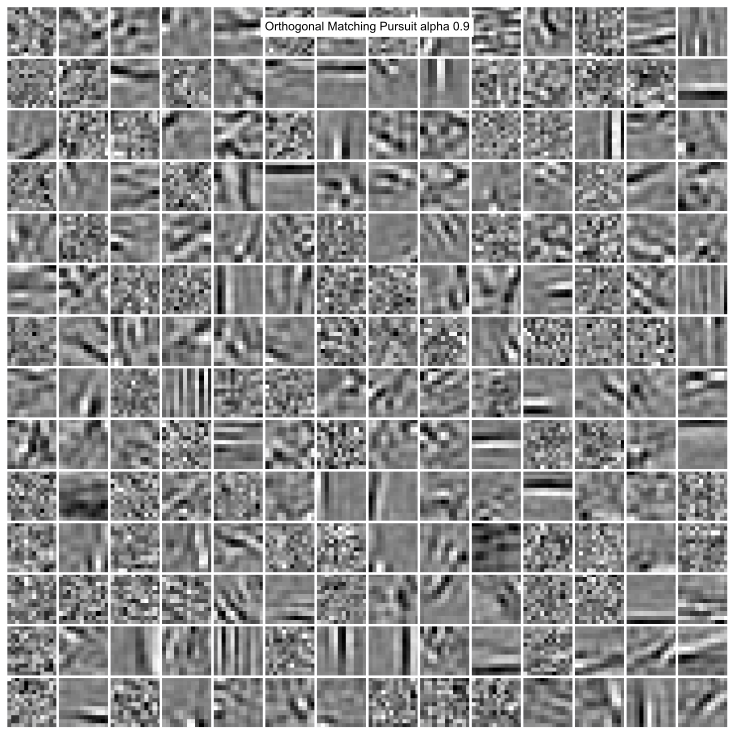

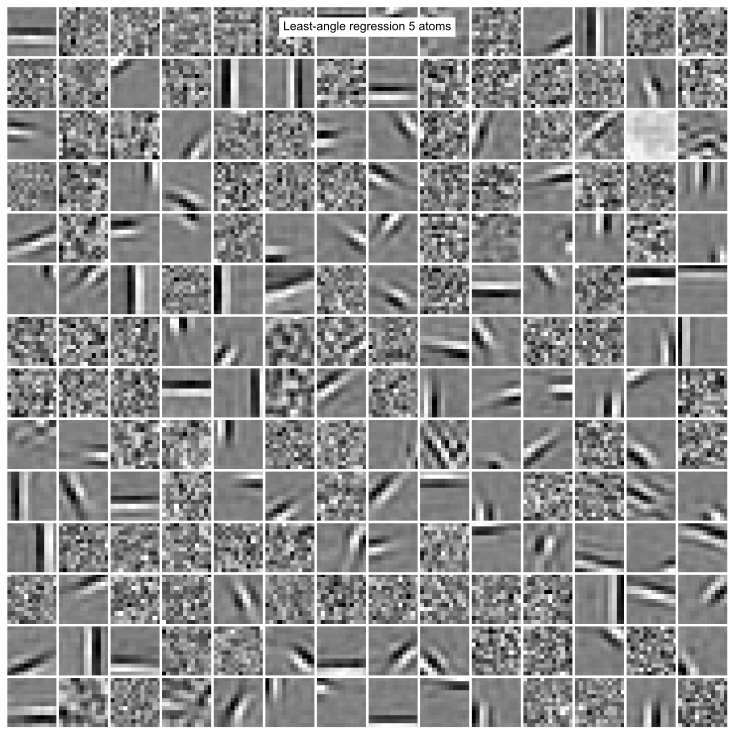

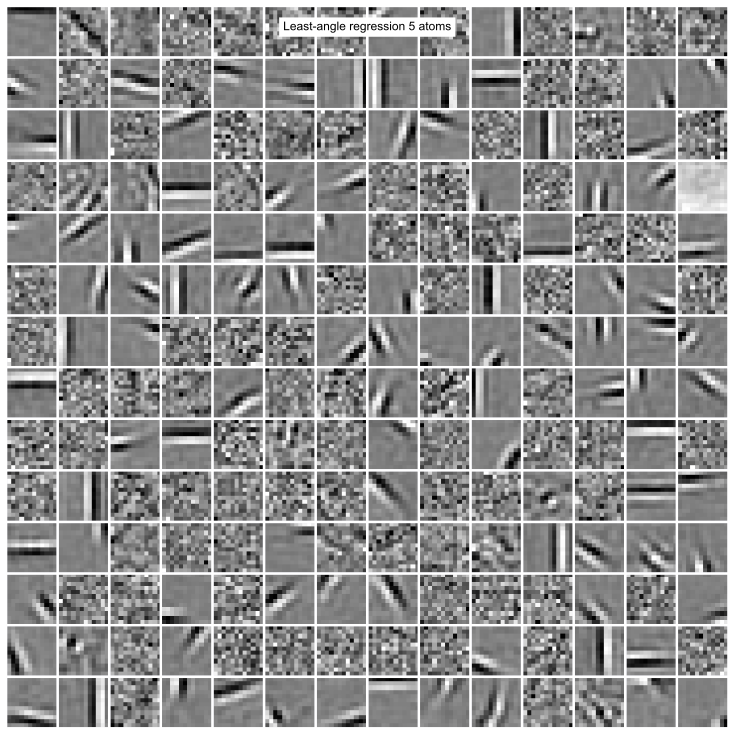

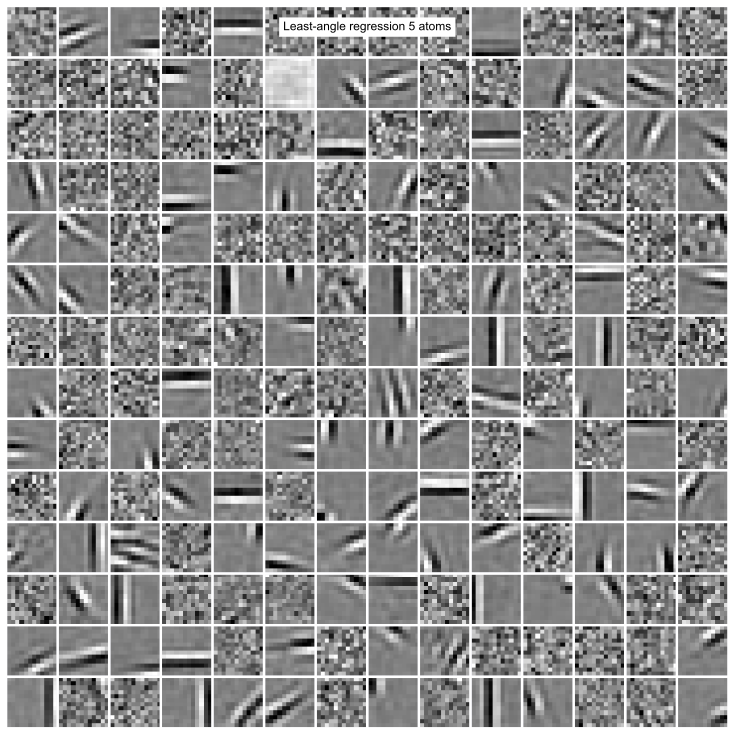

In [3]:
dicos = {}
learning_algorithms = [
    ('Orthogonal Matching Pursuit 10 atom', 'OMP1_N10',
     {'learning_algorithm':'omp', 'transform_n_nonzero_coefs': 10}),
    ('Orthogonal Matching Pursuit alpha 0.9', 'OMP_tol',
     {'learning_algorithm':'omp', 'alpha': .9}),
    ('Least-angle regression 5 atoms', 'LARS',
     {'learning_algorithm':'lars', 'transform_n_nonzero_coefs': 5}),
    ('Least-angle regression 5 atoms', 'LARS',
     {'learning_algorithm':'lasso_lars', 'transform_n_nonzero_coefs': 5}),
    ('Least-angle regression 5 atoms', 'LARS',
     {'learning_algorithm':'lasso_cd', 'transform_n_nonzero_coefs': 5})]
        
for learning_title, learning_label, learning_kwargs in learning_algorithms:
    print('Dictionary learned from image patches using ' + learning_title)
    shl = SHL(database=database, DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, verbose=verbose, eta_homeo=0., **learning_kwargs)
    dicos[learning_label] = shl.learn_dico()
    fig, ax = shl.show_dico(dicos[learning_label], title=learning_title)
    fig.show()

Let's evaluate the different dictionaries with different coding algorithms

In [4]:
from shl_scripts import SHL
###############################################################################
# Extract noisy patches and reconstruct them using the dictionary
print('Extracting noisy patches... ')
import time
t0 = time.time()
# taking Lena as the test image...
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from scipy.misc import lena
import numpy as np
lena_im = lena() / 256.0

# downsample for higher speed
lena_im = lena_im[::2, ::2] + lena_im[1::2, ::2] + lena_im[::2, 1::2] + lena_im[1::2, 1::2]
lena_im /= 4.0
height, width = lena_im.shape
lena_im = shl.slip.whitening(lena_im)

# Distort the right half of the image
distorted = lena_im.copy()
distorted[:, height // 2:] += 0.075 * np.random.randn(width, height // 2)

data = extract_patches_2d(distorted[:, height // 2:], shl.patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept

difference = distorted - lena_im
MSE_0 = np.sqrt(np.sum(difference ** 2))
print('done in %.2fs.' % (time.time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit 5 atom', 'omp', 'OMP05',
     {'transform_n_nonzero_coefs': 5}),
    ('Orthogonal Matching Pursuit 10 atoms', 'omp', 'OMP10',
     {'transform_n_nonzero_coefs': 10}),
    ('Orthogonal Matching Pursuit 20 atoms', 'omp', 'OMP20',
     {'transform_n_nonzero_coefs': 20}),
    ('Least-angle regression 5 atoms', 'lars', 'LARS',
     {'transform_n_nonzero_coefs': 5}),
#    ('Thresholding alpha=0.1', 'threshold', 'Threshold', {'transform_alpha': .1})
                        ]

MSE = np.empty((len(learning_algorithms), len(transform_algorithms)))
t0 = time.time()
reconstructions = {}
for i, (learning_title, learning_label, learning_kwargs) in enumerate(learning_algorithms):
    dico = dicos[learning_label]
    for j, (title, coding_algorithm, label, kwargs) in enumerate(transform_algorithms):
        reconstructions[title] = lena_im.copy()
        patches = shl.code(data, dico, intercept, coding_algorithm=coding_algorithm, **kwargs)
        reconstructions[title][:, height // 2:] = reconstruct_from_patches_2d(patches.reshape( (data.shape[0], shl.patch_size[0], shl.patch_size[1])), (width, height // 2))
        difference = reconstructions[title] - lena_im
        MSE[i, j] = np.sqrt(np.sum(difference ** 2))/MSE_0
        print('Denoising ratio: %.2f \n - with coding algorithm %s \n - with learning algorithm %s' 
              % (MSE[i, j] , title, learning_label))
dt = time.time() - t0
print('done in %.2fs.' % dt)

Extracting noisy patches... 
done in 0.07s.
Denoising ratio: 0.43 
 - with coding algorithm Orthogonal Matching Pursuit 5 atom 
 - with learning algorithm OMP1_N10

/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T
/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T



Denoising ratio: 0.46 
 - with coding algorithm Orthogonal Matching Pursuit 10 atoms 
 - with learning algorithm OMP1_N10
Denoising ratio: 0.57 
 - with coding algorithm Orthogonal Matching Pursuit 20 atoms 
 - with learning algorithm OMP1_N10
Denoising ratio: 0.63 
 - with coding algorithm Least-angle regression 5 atoms 
 - with learning algorithm OMP1_N10
Denoising ratio: 0.47 
 - with coding algorithm Orthogonal Matching Pursuit 5 atom 
 - with learning algorithm OMP_tol

/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T
/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T



Denoising ratio: 0.48 
 - with coding algorithm Orthogonal Matching Pursuit 10 atoms 
 - with learning algorithm OMP_tol
Denoising ratio: 0.58 
 - with coding algorithm Orthogonal Matching Pursuit 20 atoms 
 - with learning algorithm OMP_tol
Denoising ratio: 0.69 
 - with coding algorithm Least-angle regression 5 atoms 
 - with learning algorithm OMP_tol

/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T
/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T



Denoising ratio: 0.43 
 - with coding algorithm Orthogonal Matching Pursuit 5 atom 
 - with learning algorithm LARS
Denoising ratio: 0.46 
 - with coding algorithm Orthogonal Matching Pursuit 10 atoms 
 - with learning algorithm LARS

/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T
/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T



Denoising ratio: 0.55 
 - with coding algorithm Orthogonal Matching Pursuit 20 atoms 
 - with learning algorithm LARS
Denoising ratio: 0.62 
 - with coding algorithm Least-angle regression 5 atoms 
 - with learning algorithm LARS
Denoising ratio: 0.43 
 - with coding algorithm Orthogonal Matching Pursuit 5 atom 
 - with learning algorithm LARS

/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T
/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T



Denoising ratio: 0.46 
 - with coding algorithm Orthogonal Matching Pursuit 10 atoms 
 - with learning algorithm LARS
Denoising ratio: 0.55 
 - with coding algorithm Orthogonal Matching Pursuit 20 atoms 
 - with learning algorithm LARS
Denoising ratio: 0.62 
 - with coding algorithm Least-angle regression 5 atoms 
 - with learning algorithm LARS

/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T
/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T



Denoising ratio: 0.43 
 - with coding algorithm Orthogonal Matching Pursuit 5 atom 
 - with learning algorithm LARS
Denoising ratio: 0.46 
 - with coding algorithm Orthogonal Matching Pursuit 10 atoms 
 - with learning algorithm LARS

/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T
/Users/lolo/pool/libs/numbers/scikit-learn-sparsenet/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T



Denoising ratio: 0.55 
 - with coding algorithm Orthogonal Matching Pursuit 20 atoms 
 - with learning algorithm LARS
Denoising ratio: 0.62 
 - with coding algorithm Least-angle regression 5 atoms 
 - with learning algorithm LARS
done in 547.90s.


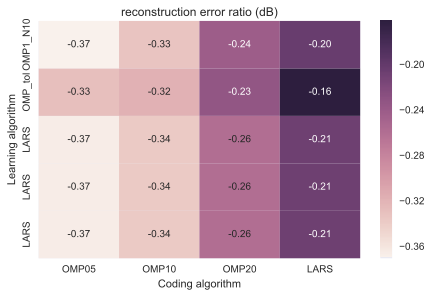

In [ ]:
sns.set()
coding_labels = []
for _, _, label, _ in transform_algorithms: coding_labels.append(label)
learning_labels = []
for _, label, _  in learning_algorithms: learning_labels.append(label)

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(np.log10(MSE), ax=ax, yticklabels=learning_labels, xticklabels=coding_labels, annot=True, fmt="0.2f")
ax.set_title('reconstruction error ratio (dB)')
ax.set_xlabel('Coding algorithm')
ax.set_ylabel('Learning algorithm')

fig.tight_layout(rect=[0.1, 0.1, .8, .8])

More generally, it is nice to compare at the coding level for OMP the compromise between SE and L0 given the different dictionaries that we have learned.

In this notebook, we have replicated the classical SparseNet algorithm of Olshausen on a  set of natural images and shown that:

 - one can denoise an image using the learned dictionary
 - that the dictionaries are qualitatively the same,
 - that the efficiency is roughly similar but best when the learning and the coding are set to Orthogonal Matching Pursuit (and that the ``threshold`` coding method is not efficient),
 
However, the dictionaries are qualitatively not the same as the one from the original paer, and this is certainly due to the lack of control in the competition during the learning phase.
Let's now try to do that [in a new notebook](https://laurentperrinet.github.io/sciblog/posts/2015-05-06-reproducing-olshausens-classical-sparsenet-part-2.html).

Below is a thorough description of what I did.

## some useful existing code from sklearn

In [ ]:
# %load http://scikit-learn.org/stable/_downloads/plot_image_denoising.py
"""
=========================================
Image denoising using dictionary learning
=========================================

An example comparing the effect of reconstructing noisy fragments
of the Lena image using firstly online :ref:`DictionaryLearning` and
various transform methods.

The dictionary is fitted on the distorted left half of the image, and
subsequently used to reconstruct the right half. Note that even better
performance could be achieved by fitting to an undistorted (i.e.
noiseless) image, but here we start from the assumption that it is not
available.

A common practice for evaluating the results of image denoising is by looking
at the difference between the reconstruction and the original image. If the
reconstruction is perfect this will look like Gaussian noise.

It can be seen from the plots that the results of :ref:`omp` with two
non-zero coefficients is a bit less biased than when keeping only one
(the edges look less prominent). It is in addition closer from the ground
truth in Frobenius norm.

The result of :ref:`least_angle_regression` is much more strongly biased: the
difference is reminiscent of the local intensity value of the original image.

Thresholding is clearly not useful for denoising, but it is here to show that
it can produce a suggestive output with very high speed, and thus be useful
for other tasks such as object classification, where performance is not
necessarily related to visualisation.

"""
print(__doc__)

import time

import matplotlib.pyplot as plt
import numpy as np

from scipy.misc import lena

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

###############################################################################
# Load Lena image and extract patches

lena = lena() / 256.0

# downsample for higher speed
lena = lena[::2, ::2] + lena[1::2, ::2] + lena[::2, 1::2] + lena[1::2, 1::2]
lena /= 4.0
height, width = lena.shape

# Distort the right half of the image
print('Distorting image...')
distorted = lena.copy()
distorted[:, height // 2:] += 0.075 * np.random.randn(width, height // 2)

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time.time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :height // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time.time() - t0))

###############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time.time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time.time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from Lena patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


###############################################################################
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, lena, 'Distorted image')

###############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time.time()
data = extract_patches_2d(distorted[:, height // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time.time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = lena.copy()
    t0 = time.time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, height // 2:] = reconstruct_from_patches_2d(
        patches, (width, height // 2))
    dt = time.time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], lena,
                   title + ' (time: %.1fs)' % dt)

plt.show()


In [ ]:
# %load http://scikit-learn.org/stable/_downloads/plot_omp.py
"""
===========================
Orthogonal Matching Pursuit
===========================

Using orthogonal matching pursuit for recovering a sparse signal from a noisy
measurement encoded with a dictionary
"""
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal

n_components, n_features = 512, 100
n_nonzero_coefs = 17

# generate the data
###################

# y = Xw
# |x|_0 = n_nonzero_coefs

y, X, w = make_sparse_coded_signal(n_samples=1,
                                   n_components=n_components,
                                   n_features=n_features,
                                   n_nonzero_coefs=n_nonzero_coefs,
                                   random_state=0)

idx, = w.nonzero()

# distort the clean signal
##########################
y_noisy = y + 0.2 * np.random.randn(len(y))

# plot the sparse signal
########################
plt.figure(figsize=(7, 7))
plt.subplot(4, 1, 1)
plt.xlim(0, 512)
plt.title("Sparse signal")
plt.stem(idx, w[idx])

# plot the noise-free reconstruction
####################################
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(X, y)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx, w[idx],'r')
plt.stem(idx_r, coef[idx_r])

# plot the noisy reconstruction
###############################
omp.fit(X, y_noisy)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(4, 1, 3)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx, w[idx],'r', alpha=.5)
plt.stem(idx_r, coef[idx_r], alpha=.5)

# plot the noisy reconstruction with number of non-zeros set by CV
##################################################################
omp_cv = OrthogonalMatchingPursuitCV()
omp_cv.fit(X, y_noisy)
coef = omp_cv.coef_
idx_r, = coef.nonzero()
plt.subplot(4, 1, 4)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements with CV")
plt.stem(idx, w[idx],'r', alpha=.5)
plt.stem(idx_r, coef[idx_r], alpha=.5)

plt.subplots_adjust(0.06, 0.04, 0.94, 0.90, 0.20, 0.38)
plt.suptitle('Sparse signal recovery with Orthogonal Matching Pursuit',
             fontsize=16)
plt.show()


In [ ]:
# %load http://scikit-learn.org/stable/_downloads/plot_dict_face_patches.py
"""
Online learning of a dictionary of parts of faces
==================================================

This example uses a large dataset of faces to learn a set of 20 x 20
images patches that constitute faces.

From the programming standpoint, it is interesting because it shows how
to use the online API of the scikit-learn to process a very large
dataset by chunks. The way we proceed is that we load an image at a time
and extract randomly 50 patches from this image. Once we have accumulated
500 of these patches (using 10 images), we run the `partial_fit` method
of the online KMeans object, MiniBatchKMeans.

The verbose setting on the MiniBatchKMeans enables us to see that some
clusters are reassigned during the successive calls to
partial-fit. This is because the number of patches that they represent
has become too low, and it is better to choose a random new
cluster.
"""
print(__doc__)

import time

import matplotlib.pyplot as plt
import numpy as np


from sklearn import datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

faces = datasets.fetch_olivetti_faces()

###############################################################################
# Learn the dictionary of images

print('Learning the dictionary... ')
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True)
patch_size = (20, 20)

buffer = []
index = 1
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50,
                                  random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print('Partial fit of %4i out of %i'
                  % (index, 6 * len(faces.images)))

dt = time.time() - t0
print('done in %.2fs.' % dt)

###############################################################################
# Plot the results
plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())


plt.suptitle('Patches of faces\nTrain time %.1fs on %d patches' %
             (dt, 8 * len(faces.images)), fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()


## great, let's merge them into a new version  of the classical algorithm

Basically, we keep the same code as the first example, but with:
 
 - no distorsion of image denoising -- we will assess the results by the coding efficiency,
 - whitening of the images (as in Olshausen) befor taking patches,
 - bigger patches,
 - a bigger set of natural images,
 - a longer learning
 - testing different ``transform_algorithm``s as learning and coding algorithms,
 - uses online learning from the third example (however, this slows down things...)
 
What differs from the original algorithm is mainly 
 
 - the learning method is modified,
 - the way that the norm of the filters is controlled. Here, sklearn simply assumes that $ || V_k ||_2 = 1$,  $\forall k$ (with $0 <= k < n_{components}$). We will see that this may be a problem. 
 
 More details on ``MiniBatchDictionaryLearning``:
 
 - doc page: http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.MiniBatchDictionaryLearning.html
 - source code : https://github.com/scikit-learn/scikit-learn/blob/bb39b49/sklearn/decomposition/dict_learning.py#L1018

Note that using ``partial_fit`` or ``n_jobs`` did not improve the speed of the algorithm.

## scanning some parameters

Let's explore the dictionaries obtained when modifyng some of the parameters of the OMP algorithm.


In [ ]:
from shl_scripts import SHL

for eta in np.logspace(-3, -1.5, int(15/(DEBUG_DOWNSCALE)**.3), base=10, endpoint=False):
    shl = SHL(database=database, DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, eta=eta, verbose=verbose, eta_homeo=0.)
    dico = shl.learn_dico()
    fig, ax = shl.show_dico(dico, title='eta={}'.format(eta))
    fig.show()


<!-- TEASER_END -->

* In [an extension](https://laurentperrinet.github.io/sciblog/posts/2015-05-06-reproducing-olshausens-classical-sparsenet-part-2.html), we will study how homeostasis (cooperation) may be an essential ingredient to this algorithm working on a winner-take-all basis (competition). This extension has been published as Perrinet, Neural Computation (2010) (see  https://laurentperrinet.github.io/publication/perrinet-10-shl ).

* all comments and bug corrections should be submitted to Laurent Perrinet at Laurent.Perrinet@univ-amu.fr
* find out updates on https://laurentperrinet.github.io/publication/perrinet-19-hulk and https://github.com/bicv/SHL_scripts
    
    